In [1]:
import pandas as pd
import operator
import torch
from torch.utils.data import Dataset
import numpy as np

def extract_id(row):
    return np.int32(row.split(":")[0])

def extract_value(row):
    return np.float32(row.split(":")[1])

class CTR_Dataset(Dataset):
    def __init__(self, id_df, value_df):
        self.x_id = torch.LongTensor(np.array(id_df.drop(columns=['rating'])))
        self.y = torch.Tensor(np.array(id_df['rating']))
        self.x_value = torch.Tensor(np.array(value_df))

    def __getitem__(self, idx):
        return self.x_id[idx], self.x_value[idx], self.y[idx]

    def __len__(self):
        return len(self.x_id)

In [ ]:
path = "criteo/train.libsvm"
# path = "criteo/valid.libsvm"
headers = [f"column_{i}" for i in range(1,41)]

# extract feature id and feature value
print("Extracting feature id and feature value...")
df = pd.read_csv(path,sep=" ",names=headers)
df_id = df.iloc[:,1:].applymap(extract_id)
df_value = df.iloc[:,1:].applymap(extract_value)
# del df
# df_id = df_id.astype('int32')
# df_value = df_value.astype('float32')

Extracting feature id and feature value...


In [6]:
df_rating = df["column_1"].copy(deep=True)

In [ ]:
del df

In [ ]:
# remap feature id according to feature frequency
print("Remapping feature id according to feature frequency...")
id_list=[]
freq_list=[]
for i in range(2,41):
    id_list += df_id.groupby(f"column_{i}").size().index.to_list()
    freq_list += df_id.groupby(f"column_{i}").size().to_list()
merge_dict = {id_list[i]:freq_list[i] for i in range(len(id_list))}
sorted_list= sorted(merge_dict.items(), key=operator.itemgetter(1))[::-1]
train_id_mapping = {sorted_list[i][0]:i for i in range(len(sorted_list))}
df_id_remap = df_id.applymap(train_id_mapping.get)

In [12]:
# construct dataset
print("Constructing dataset...")
df_id_remap["rating"]=df_rating
dataset = CTR_Dataset(df_id_remap,df_value)

Constructing dataset...


In [16]:
import pickle
with open("train_dataset_and_mapping.pickle",'wb') as f:
    pickle.dump([dataset,train_id_mapping], f, protocol=4)
    print("File saved")

File saved


In [3]:
import pickle
with open("train_dataset_and_mapping.pickle",'rb') as f:
    dataset, train_id_mapping = pickle.load(f)

In [17]:
with open("train_id_mapping.pickle",'wb') as f:
    pickle.dump([train_id_mapping], f)
    print("File saved")

File saved


In [3]:
import pickle
with open("train_id_mapping.pickle",'rb') as f:
    train_id_mapping=pickle.load(f)[0]

In [14]:
import numpy as np
np.array(list(train_id_mapping.keys())).max()

2086974

In [2]:
def id_remap_train(key):
    try:
        return train_id_mapping[key]
    except:
        return 2086975

In [ ]:
path = "criteo/valid.libsvm"
headers = [f"column_{i}" for i in range(1,41)]

# extract feature id and feature value
print("Extracting feature id and feature value...")
df = pd.read_csv(path,sep=" ",names=headers)
df_id = df.iloc[:,1:].applymap(extract_id)
df_value = df.iloc[:,1:].applymap(extract_value)
df_rating = df["column_1"].copy(deep=True)
del df
# remap feature id according to feature frequency
print("Remapping feature id according to feature frequency...")
df_id_remap = df_id.applymap(id_remap_train)
# construct dataset
print("Constructing dataset...")
df_id_remap["rating"]=df_rating
dataset = CTR_Dataset(df_id_remap,df_value)
with open("valid_dataset.pickle",'wb') as f:
    pickle.dump([dataset], f, protocol=4)
    print("File saved")

Extracting feature id and feature value...
Remapping feature id according to feature frequency...


In [4]:
path = "criteo/test.libsvm"
headers = [f"column_{i}" for i in range(1,41)]

# extract feature id and feature value
print("Extracting feature id and feature value...")
df = pd.read_csv(path,sep=" ",names=headers)
df_id = df.iloc[:,1:].applymap(extract_id)
df_value = df.iloc[:,1:].applymap(extract_value)
df_rating = df["column_1"].copy(deep=True)
del df
# remap feature id according to feature frequency
print("Remapping feature id according to feature frequency...")
df_id_remap = df_id.applymap(id_remap_train)
# construct dataset
print("Constructing dataset...")
df_id_remap["rating"]=df_rating
dataset = CTR_Dataset(df_id_remap,df_value)
with open("test_dataset.pickle",'wb') as f:
    pickle.dump([dataset], f, protocol=4)
    print("File saved")

Extracting feature id and feature value...
Remapping feature id according to feature frequency...
Constructing dataset...
File saved


In [2]:
import pickle
with open("train_dataset_and_mapping.pickle",'rb') as f:
    train_dataset, _ = pickle.load(f)
with open("valid_dataset.pickle",'rb') as f:
    valid_dataset = pickle.load(f)
with open("test_dataset.pickle",'rb') as f:
    test_dataset = pickle.load(f)

In [4]:
datasets = [train_dataset, valid_dataset, test_dataset, 2086976]
with open("criteo/datasets.pickle", 'wb') as f:
    pickle.dump(datasets, f, protocol=4)
    print("File saved.")

File saved.


In [6]:
with open("valid_dataset.pickle",'rb') as f:
    valid_dataset = pickle.load(f)

In [30]:
valid_dataset[0][0][0]

tensor([    12,     11,     10,      9,      8,      7,      6,      5,      4,
             3,      2,      1,      0,    560,    629,   1284,   1283,     59,
            36, 197495,     16,     13,     30,   5761,   1282,   5759,     27,
          1667,   1281,     62,    821,     20,     22,   1280,     14,    218,
           485,     21,     19])

In [32]:
size_array = np.zeros(2086976)

In [33]:
valid_dataset[0][0][0][0].item()

12

In [35]:
for data in valid_dataset[0]:
    size_array[data[0].tolist()]+=1

In [44]:
sum=0
size_sum = size_array.sum()
index = 1
for i,size in enumerate(size_array):
    sum+=size
    if sum//(size_sum//10*index)==1:
        print(f"i={i} for index {index}")
        print(f"ratio: {i/(size_array.shape[0])}")
        index+=1

i=3 for index 1
ratio: 1.4374865834585543e-06
i=7 for index 2
ratio: 3.3541353614032936e-06
i=11 for index 3
ratio: 5.270784139348033e-06
i=16 for index 4
ratio: 7.666595111778957e-06
i=25 for index 5
ratio: 1.197905486215462e-05
i=42 for index 6
ratio: 2.0124812168419763e-05
i=127 for index 7
ratio: 6.085359869974547e-05
i=945 for index 8
ratio: 0.00045280827378944464
i=7619 for index 9
ratio: 0.003650736759790242
i=2086975 for index 10
ratio: 0.9999995208378055


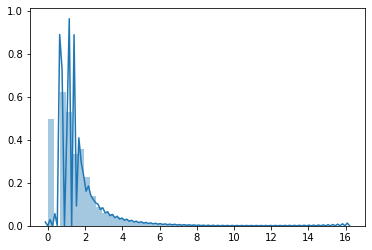

In [63]:
import seaborn as sns

sns.distplot(np.log(size_array+1))

In [67]:
size_max = np.log(size_array[0])
index = 1
for i,size in enumerate(size_array[::-1]):
    if np.log(size)//(size_max//10*index)==1:
        print(f"i={i} for index {index}")
        print(f"ratio: {i/(size_array.shape[0])}")
        index+=1

/home/chengweiyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/chengweiyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


i=686 for index 1
ratio: 0.00032870526541752275
i=688 for index 2
ratio: 0.00032966358980649515
i=1462499 for index 3
ratio: 0.7007742302738508
i=1896826 for index 4
ratio: 0.9088873087184519
i=1998980 for index 5
ratio: 0.9578356435339936
i=2049260 for index 6
ratio: 0.9819279186727591
i=2067979 for index 7
ratio: 0.990897355791346
i=2080119 for index 8
ratio: 0.9967143848324083
i=2084638 for index 9
ratio: 0.9988797187892913
i=2086114 for index 10
ratio: 0.9995869621883529
i=2086663 for index 11
ratio: 0.9998500222331258
i=2086839 for index 12
ratio: 0.9999343547793554
i=2086910 for index 13
ratio: 0.9999683752951639
i=2086930 for index 14
ratio: 0.9999779585390537
i=2086948 for index 15
ratio: 0.9999865834585544
i=2086963 for index 16
ratio: 0.9999937708914717


In [71]:
bulk_num = 100
bulk = size_array.shape[0]//bulk_num
for i in range(bulk_num):
    print(f"i={i}, max={size_array[i*bulk:(i+1)*bulk].max()}, min={size_array[i*bulk:(i+1)*bulk].min()}")

i=0, max=9595869.0, min=479.0
i=1, max=948.0, min=153.0
i=2, max=392.0, min=68.0
i=3, max=220.0, min=41.0
i=4, max=154.0, min=24.0
i=5, max=130.0, min=17.0
i=6, max=83.0, min=3.0
i=7, max=74.0, min=4.0
i=8, max=69.0, min=4.0
i=9, max=63.0, min=3.0
i=10, max=51.0, min=2.0
i=11, max=46.0, min=1.0
i=12, max=44.0, min=1.0
i=13, max=41.0, min=0.0
i=14, max=39.0, min=0.0
i=15, max=37.0, min=0.0
i=16, max=33.0, min=0.0
i=17, max=33.0, min=0.0
i=18, max=31.0, min=0.0
i=19, max=28.0, min=0.0
i=20, max=27.0, min=0.0
i=21, max=27.0, min=0.0
i=22, max=26.0, min=0.0
i=23, max=24.0, min=0.0
i=24, max=22.0, min=0.0
i=25, max=19.0, min=0.0
i=26, max=26.0, min=0.0
i=27, max=26.0, min=0.0
i=28, max=19.0, min=0.0
i=29, max=21.0, min=0.0
i=30, max=20.0, min=0.0
i=31, max=20.0, min=0.0
i=32, max=20.0, min=0.0
i=33, max=20.0, min=0.0
i=34, max=20.0, min=0.0
i=35, max=20.0, min=0.0
i=36, max=20.0, min=0.0
i=37, max=17.0, min=0.0
i=38, max=16.0, min=0.0
i=39, max=17.0, min=0.0
i=40, max=17.0, min=0.0
i=41, ma

In [77]:
size_max = size_array[0]
mag = 1
index=0
l=[]
for i,size in enumerate(size_array[::-1]):
    if size>=mag:
        l+=[size_array.shape[0]-i]
        print(f"i={size_array.shape[0]-i} for index {index}")
        print(f"ratio: {i/(size_array.shape[0])}")
        mag*=10
        index+=1

i=2086976 for index 0
ratio: 0.0
i=2086222 for index 1
ratio: 0.0003612882946425833
i=110262 for index 2
ratio: 0.9471666181115643
i=18997 for index 3
ratio: 0.990897355791346
i=1940 for index 4
ratio: 0.9990704253426969
i=177 for index 5
ratio: 0.999915188291576
i=51 for index 6
ratio: 0.9999755627280812


In [79]:
l=np.array(l)

In [80]:
l[:-1]-l[1:]

array([    754, 1975960,   91265,   17057,    1763,     126])

In [82]:
!ls ../checkpoint

dnis-ctr-4_warm_start_0.pth  warm_start_model_14.pth
nas_31.tar		     warm_start_model_4.pth
warm_start_64_14.pth	     warm_start_noproject_14.pth
warm_start_model_0.pth
